# <span style='color:green'>1.0 Arrival Data Frame </span>
## Goals of the Project 
- The goal of this Notebook is to implement Exploration Data Analysis.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import dateutil.parser as parser
from datetime import datetime
import dateutil.parser as parser
from datetime import datetime
from sklearn.linear_model import LinearRegression  #to build a linear regression
%config InlineBackend.figure_format = 'retina'

In [2]:
%store -r Arrival_DF
Arrival_DF.shape

(363575, 24)

In [3]:
# Converting Columns to their respective dtypes
Arrival_DF['boarded pax'] = Arrival_DF['boarded pax'].astype(int)
Arrival_DF['Original Airport'] = Arrival_DF['Original Airport'].astype(str)
Arrival_DF['Destination airport'] = Arrival_DF['Destination airport'].astype(
    str)
Arrival_DF['Arrival Datetime'] = Arrival_DF['Arrival Datetime'].apply(
    pd.to_datetime)
Arrival_DF['Original Airport'] = Arrival_DF['Original Airport'].astype(str)
Arrival_DF['Terminal'] = Arrival_DF['Terminal'].astype(str)
Arrival_DF['Flight Number'] = Arrival_DF['Flight Number'].astype(str)
Arrival_DF['Seat Capacity'] = Arrival_DF['Seat Capacity'].astype(int)

In [4]:
def percent_0_boarded_pax(df, column_name):
    rows_0_pax = df[df[column_name] == 0]
    percent_0 = (len(rows_0_pax) / len(df)) * 100
    print(f'The percentage of rows with 0 passangers from column named {column_name} is  {percent_0} %')

In [5]:
percent_0_boarded_pax(Arrival_DF,'boarded pax')
percent_0_boarded_pax(Arrival_DF,'Seat Capacity')

The percentage of rows with 0 passangers from column named boarded pax is  11.877054252905179 %
The percentage of rows with 0 passangers from column named Seat Capacity is  1.0803823145155746 %


In [6]:
# Removing duplicate values .
Arrival_DF=Arrival_DF.drop_duplicates()

In [7]:
def remove_infinite_number(df, column_name):
    '''
    The purpose of this function is to eliminate set Capacity values showing 0 , this is due to that boarded pax devided 
    by the Seat Capacity will provide an inf value , this will further prevent further calculations. In addition to that,
    We can not have a passanger flight with only 0 passangers. This will also be eliminated. 
    '''

    df = df[df[column_name] != 0]
    return df

In [8]:
Arrival_DF = remove_infinite_number(Arrival_DF,'Seat Capacity')
Arrival_DF = remove_infinite_number(Arrival_DF,'boarded pax')

### 5.  Pax Ratio Calculation 

I am going to find the ratio of the Pax number over the Aircraft capacity ie : 
- Pax ratio is defined as the ratio of the boarded pax to the Aircraft Capacity
$$
PA_r=Paxt/Seats
$$
where PA_r stands for Passanger Aircraft Ratio 

In [9]:
Arrival_DF.loc[:,"PAr"]=round((Arrival_DF['boarded pax']/Arrival_DF['Seat Capacity']),4)# round it to 4.sf
Arrival_DF.shape

(318343, 25)

#### Extracting Month and Week Number from the the Date format 

In [10]:
Arrival_DF.loc[:,"Month"]=Arrival_DF["Date"].dt.strftime('%B')
Arrival_DF.loc[:,"WN"]=Arrival_DF["Date"].dt.isocalendar().week
Arrival_DF.loc[:,"Year"]=Arrival_DF.loc[:,"Date"].dt.year

#### Converting traffic types 
- To create a situation where we have the same name for International and Domestic Flights , a function was created to ensure that `´Int`´ is represented by `´I`´ and `´Dom`´ is represented with `´D`´

In [11]:
def convert_traffic_type(df, column_name):
    '''
    The goal of this function is to convert traffic types into corresponding I and D representing International flights 
    and Domestic flights respectively .
    '''
    df[column_name] = df[column_name].replace('INT', 'I')
    df[column_name] = df[column_name].replace('DOM', 'D')
    return df

In [12]:
Arrival_DF = convert_traffic_type(Arrival_DF, 'traffic_type')

### Implementing a whister plot to elimiante any outliers
 This will be apppled to the PAR aka passanger load factor, in that way , I will be able to eliminate out any non-useful results . 

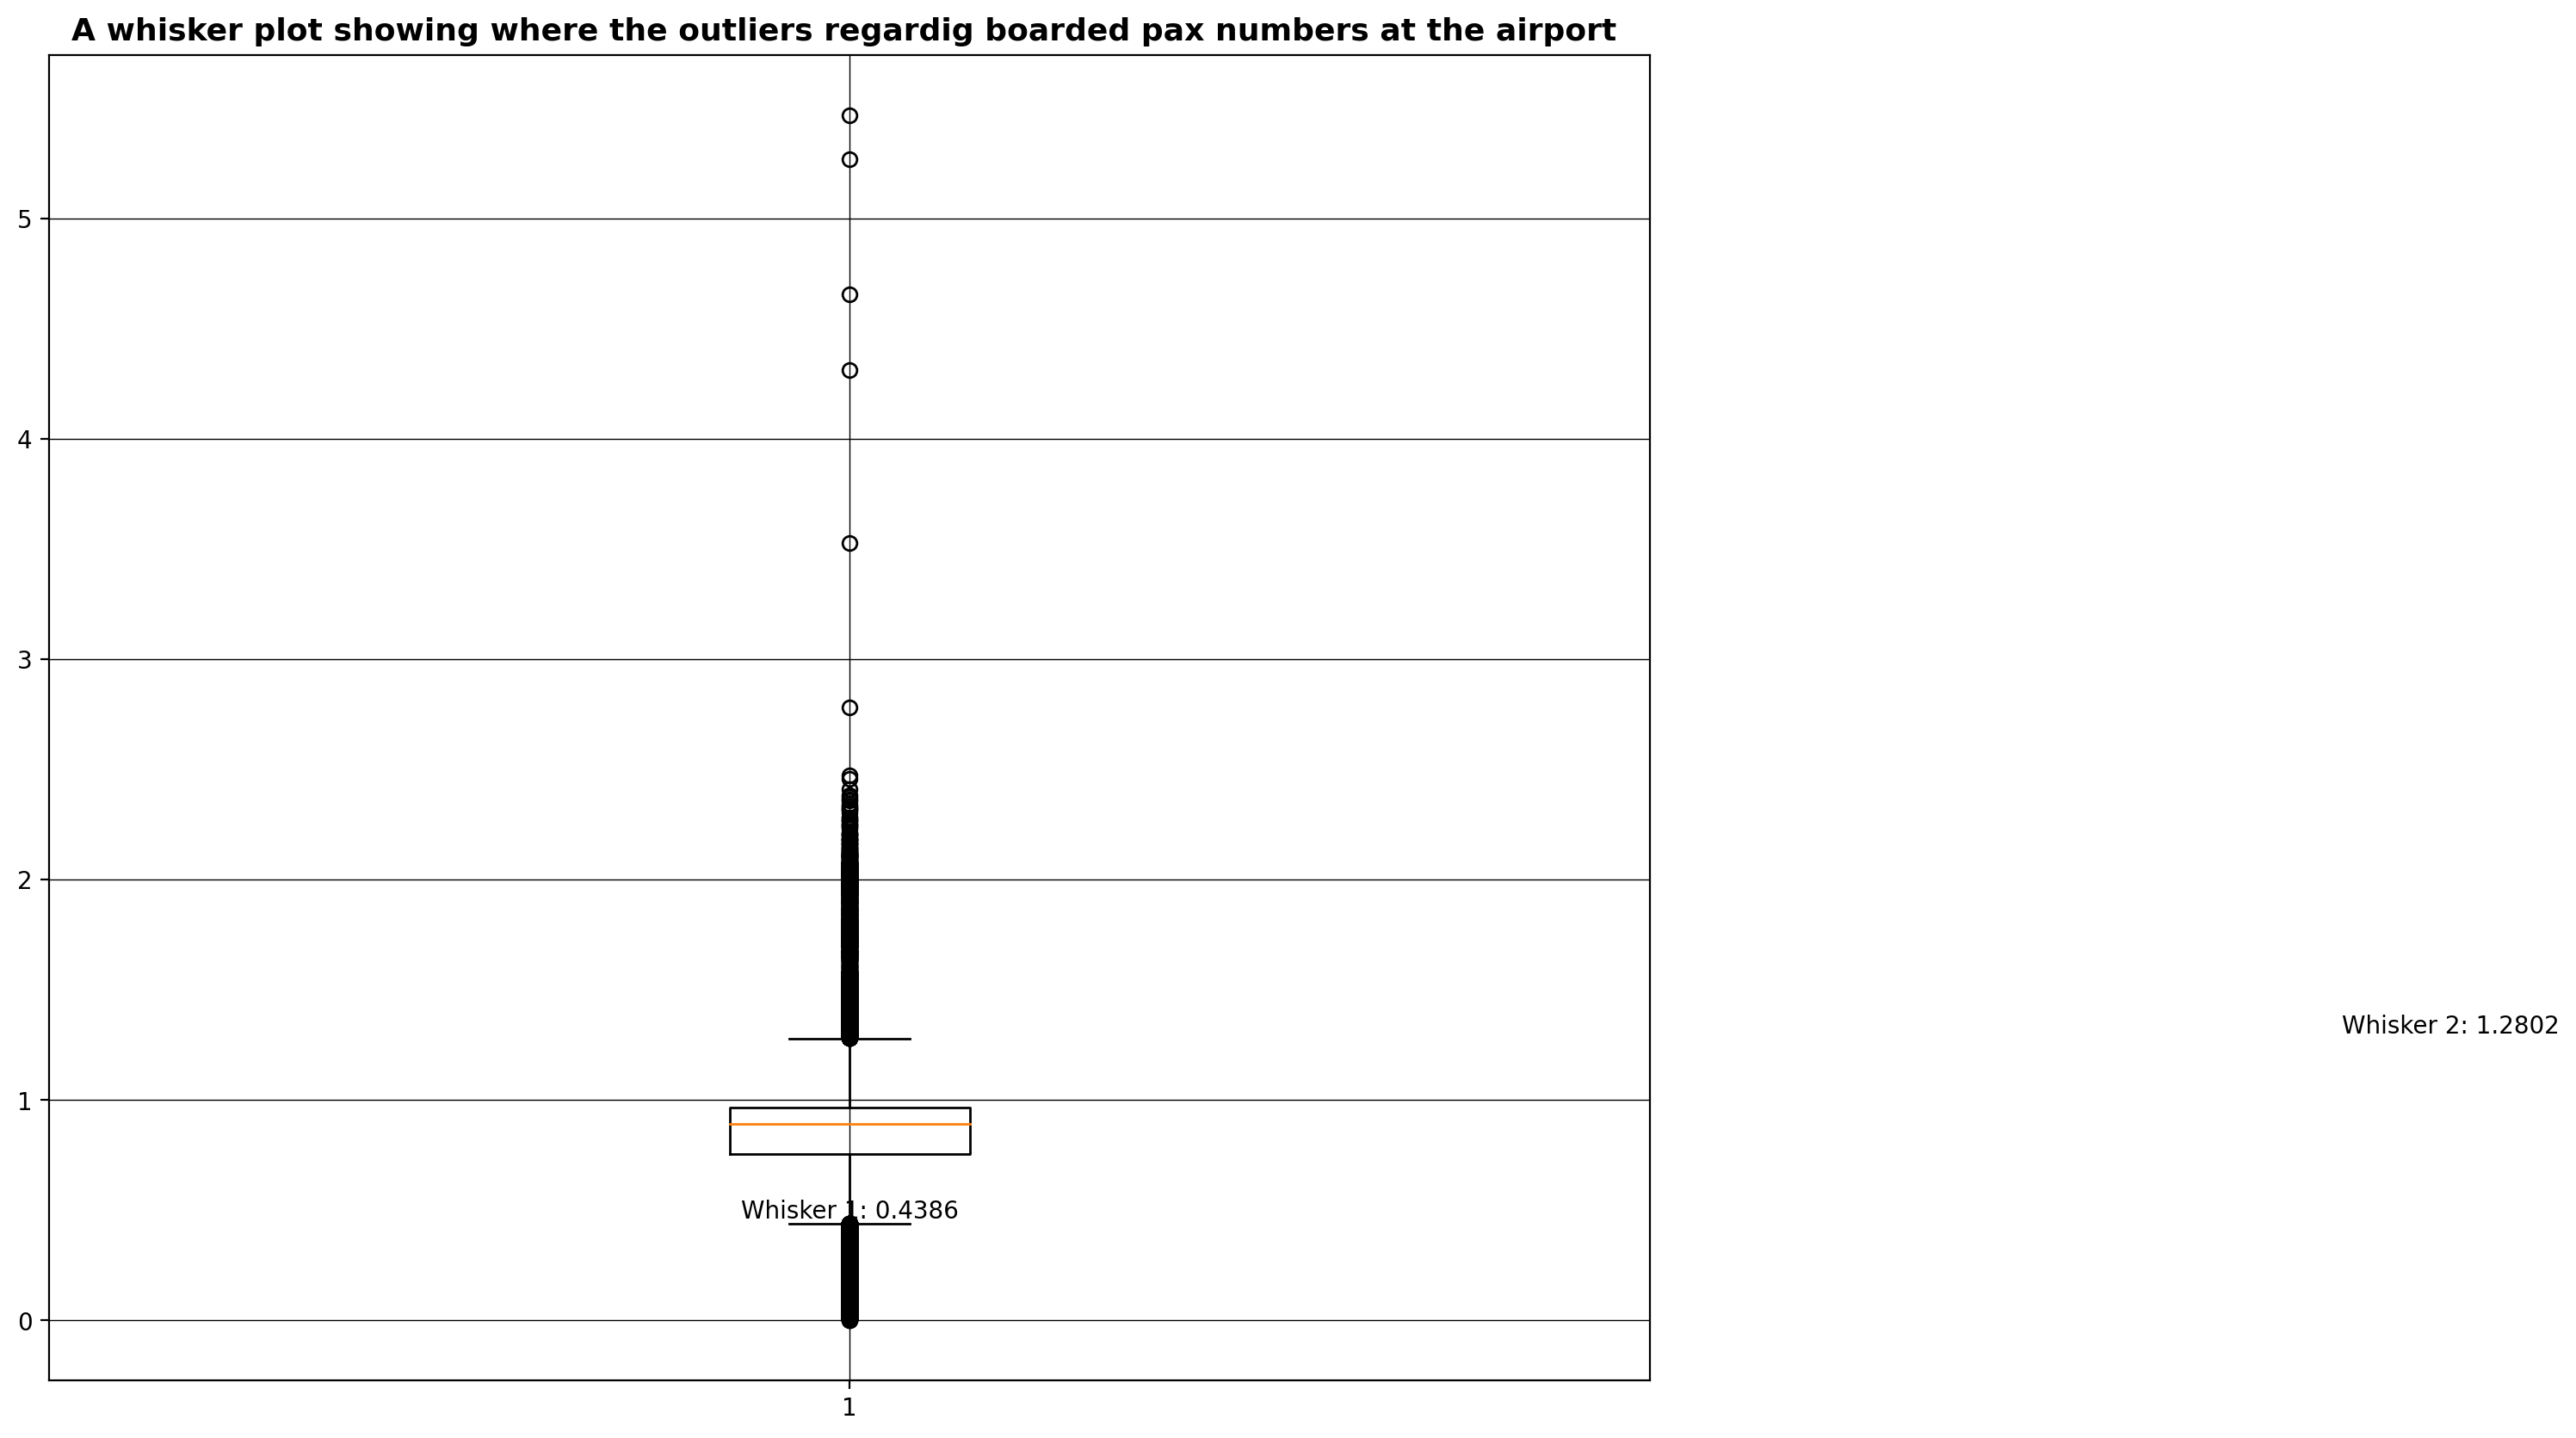

In [13]:
# Create a figure with a size of 10 by 8
plt.figure(figsize=(12, 10))

# Assuming DF_Date is your DataFrame
B = plt.boxplot(Arrival_DF['PAr'])

# Extract the whisker values
whiskers = [item.get_ydata() for item in B['whiskers']]

# Label the whiskers and print their values
for i in range(len(whiskers)):
    plt.text(float(i + 1),
             whiskers[i][1],
             f'Whisker {i+1}: {whiskers[i][1]}',
             ha='center',
             va='bottom')

# Add black gridlines on all axes with a gridwidth of 0.5
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.title(
    "A whisker plot showing where the outliers regardig boarded pax numbers at the airport ",
    fontsize=13,
    fontweight="bold")

# Show the plot
plt.show()

In [14]:
whiskers_bottom = whiskers[0][0] 
whiskers_top = whiskers[1][1] 

In [15]:
def clean_df_after_outliers(df, column_name, whiskers_bottom, whiskers_top):
    '''
    The goal of this function is to select only Pax load rows within the whisker values , However, Knoweldge shows that
    we can not have a pax load more than 1 meaning that the best user case scenario is under the assumption that the 
    plane is full to the brim. This in short means one thing, a plane have a load pax of more than 1 is by no means a 
    possiblity . 
    '''
    if whiskers_top >= 1:
        whiskers_top = 1
    df = df[(df[column_name] > whiskers_bottom)
            & (df[column_name] < whiskers_top)]
    return df

In [16]:
Arrival_DF = clean_df_after_outliers(Arrival_DF,'PAr',whiskers_bottom,whiskers_top)

In [17]:
Arrival_DF['time'] = pd.to_datetime(Arrival_DF['Arrival Datetime']).dt.time

In [18]:
def round_nearest_hour(df, column_name):
    df[column_name] = (df[column_name] +
                       pd.DateOffset(minutes=30)).dt.floor('H').dt.time
    return df

In [19]:
Arrival_DF = round_nearest_hour(Arrival_DF,'Arrival Datetime')

In [20]:
Arrival_DF['Arrival Datetime'].dtype

dtype('O')

In [21]:
Arrival_DF = Arrival_DF[[
    'Day of week', 'Weekend (0/1)', 'Holiday (0/1)', 'Festival',
    'Overlap with Weekend', 'Extended weekend', '1day_after', '2day_after',
    '3day_after', '1day_before', '2day_before', '3day_before', '4day_before',
    '4day_after', 'boarded pax', 'Original Airport', 'Arrival Datetime',
    'Seat Capacity', 'traffic_type', 'Terminal', 'Airline Code', 'PAr',
    'Month', 'WN', 'Year'
]]

In [22]:
Feature_Selection = Arrival_DF

In [23]:
%store Feature_Selection 

Stored 'Feature_Selection' (DataFrame)
